# Event Analysis

TODO:
- possible to define volume in the sewer based on sensors?
- or somehow define in sewer capacity?

- maybe remove the `base flow` form the `stromwater flow`


### Initialize

In [1]:
import os

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import h5py
from anytree import Node, RenderTree
import nexusformat.nexus as nx
import pickle
from tqdm import tqdm
from mlxtend.plotting import scatterplotmatrix
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import matplotlib.cm as cm




from fault_management_uds.data.data_utilities import print_tree
from fault_management_uds.data.load_save_data import load_dataframe, save_dataframe, overwrite_dataset, save_filtered_data
from fault_management_uds.data.load_save_data import save_metadata, load_metadata, import_metadata
from fault_management_uds.plots import set_meaningful_xaxis_timestamps, get_segment_start_end_color, visualize_single_timeline


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR
from fault_management_uds.config import rain_gauges, natural_structure_order, natural_sensor_order, series_order

2024-10-08 09:43:51.950 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [2]:
np.random.seed(11)

### Load data

In [3]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'
f = print_tree(data_file_path)

root
├── dummy
└── processed
    ├── combined_data
    │   ├── cleaned
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── interpolated
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── is_error
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── no_data
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── raw
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── single_series
        ├── 5425
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── 5427
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level1
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level2
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F05R_LevelBasin
        │   ├── columns
        │   ├── data
        │   └

In [4]:
# load the timestamps
timestamps = f['processed']['combined_data']['raw']['timestamps'][:]
timestamps = pd.to_datetime(timestamps)
starttime = timestamps[0]
endtime = timestamps[-1]
print(f"Start time: {starttime} - End time: {endtime}")

Start time: 2010-01-01 00:00:00 - End time: 2021-08-19 00:00:00


##### Subset

In [5]:

raw_path = '/processed/combined_data/raw'
is_error_path = '/processed/combined_data/is_error'
no_data_path = '/processed/combined_data/no_data'

# starttime = "01-01-2019 00:00:00"
# endtime = "01-01-2021 00:00:00"

return_type = "df"

In [6]:
# load
raw, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(
    data_file_path, raw_path, 
    return_type=return_type, starttime=starttime, endtime=endtime
    )
    
is_error, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(
    data_file_path, is_error_path, 
    return_type=return_type, starttime=starttime, endtime=endtime
    )

no_data, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(
    data_file_path, no_data_path, 
    return_type=return_type, starttime=starttime, endtime=endtime
    )


# fill na with 0
raw = raw.fillna(0)
is_error = is_error.fillna(0)
no_data = no_data.fillna(0)

# readjust the order of the columns
raw = raw[series_order]
is_error = is_error[series_order]
no_data = no_data[series_order]

        Data loaded from group '/processed/combined_data/raw'
        Data loaded from group '/processed/combined_data/is_error'
        Data loaded from group '/processed/combined_data/no_data'


In [7]:
indicator_metadata = {
    # Plotting order
    'No Data': {
        'color': 'linen',
        'value': 2
    },
    'Data': {
        'color': 'forestgreen',
        'value': 1
    },
    'Zero Valued': {
        'color': 'lightgreen',
        'value': 0
    },
    'Error': {
        'color': 'firebrick',
        'value': 3
    }
}

# create the index to color mapping
indicator_2_color = {v['value']: v['color'] for k, v in indicator_metadata.items()}
indicator_2_name = {v['value']: k for k, v in indicator_metadata.items()}
name_2_color = {k: v['color'] for k, v in indicator_metadata.items()}
color_2_name = {v['color']: k for k, v in indicator_metadata.items()}


In [8]:
def create_combined_I(raw, is_error, no_data):

    timestamps_df = pd.DataFrame(raw.index, columns=['time'])
    I = np.zeros_like(raw) # 0 where there is zero value data
    I[(raw > 0).values] = 1 # 1 where there is data
    I[(no_data > 0).values] = 2 # 2 where there is no data
    I[(is_error > 0).values] = 3 # 3 where there is an error

    return I, timestamps_df

In [9]:

I, timestamps_df = create_combined_I(raw, is_error, no_data)

series = list(raw.columns)


## Selecting event and visualizing variables

TODO:
- similar to single series

In [10]:
def get_combined_event(raw, is_error, no_data, I, timestamps, starttime, endtime):
    start_idx = timestamps[timestamps['time'] == starttime].index[0]
    end_idx = timestamps[timestamps['time'] == endtime].index[0]

    raw_event = raw.iloc[start_idx:end_idx]
    is_error_event = is_error.iloc[start_idx:end_idx]
    no_data_event = no_data.iloc[start_idx:end_idx]
    I_event = I[start_idx:end_idx]
    timestamps_event = timestamps.iloc[start_idx:end_idx]

    # reset indices
    raw_event.reset_index(drop=True, inplace=True)
    is_error_event.reset_index(drop=True, inplace=True)
    no_data_event.reset_index(drop=True, inplace=True)
    timestamps_event.reset_index(drop=True, inplace=True)

    return raw_event, is_error_event, no_data_event, I_event, timestamps_event


In [11]:

# Define the time range
starttime = "2020-01-31 18:00:00"
endtime = "2020-02-02 18:00:00"


raw_event, is_error_event, no_data_event, I_event, timestamps_event = get_combined_event(raw, is_error, no_data, I, timestamps_df, starttime, endtime)
print(raw_event.shape, is_error_event.shape, no_data_event.shape, I_event.shape, timestamps_event.shape)

(2880, 17) (2880, 17) (2880, 17) (2880, 17) (2880, 1)


In [12]:
def visualize_series_with_error(ax, series, I, timestamps, indicator_2_color, name_2_color):
    # visualize the raw value
    ax.plot(range(len(series)), series, color='chocolate', label='Raw', linewidth=0.8)
    segment_starts, segment_ends, segment_color = get_segment_start_end_color(I, indicator_2_color)
    # visualize the segments with axvspan
    for start, end, color in zip(segment_starts, segment_ends, segment_color):
        #if color not in ['forestgreen', 'lightgreen']:
        ax.axvspan(start, end, alpha=0.3, facecolor=color)
    # remvoe the outer frame
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
    return ax

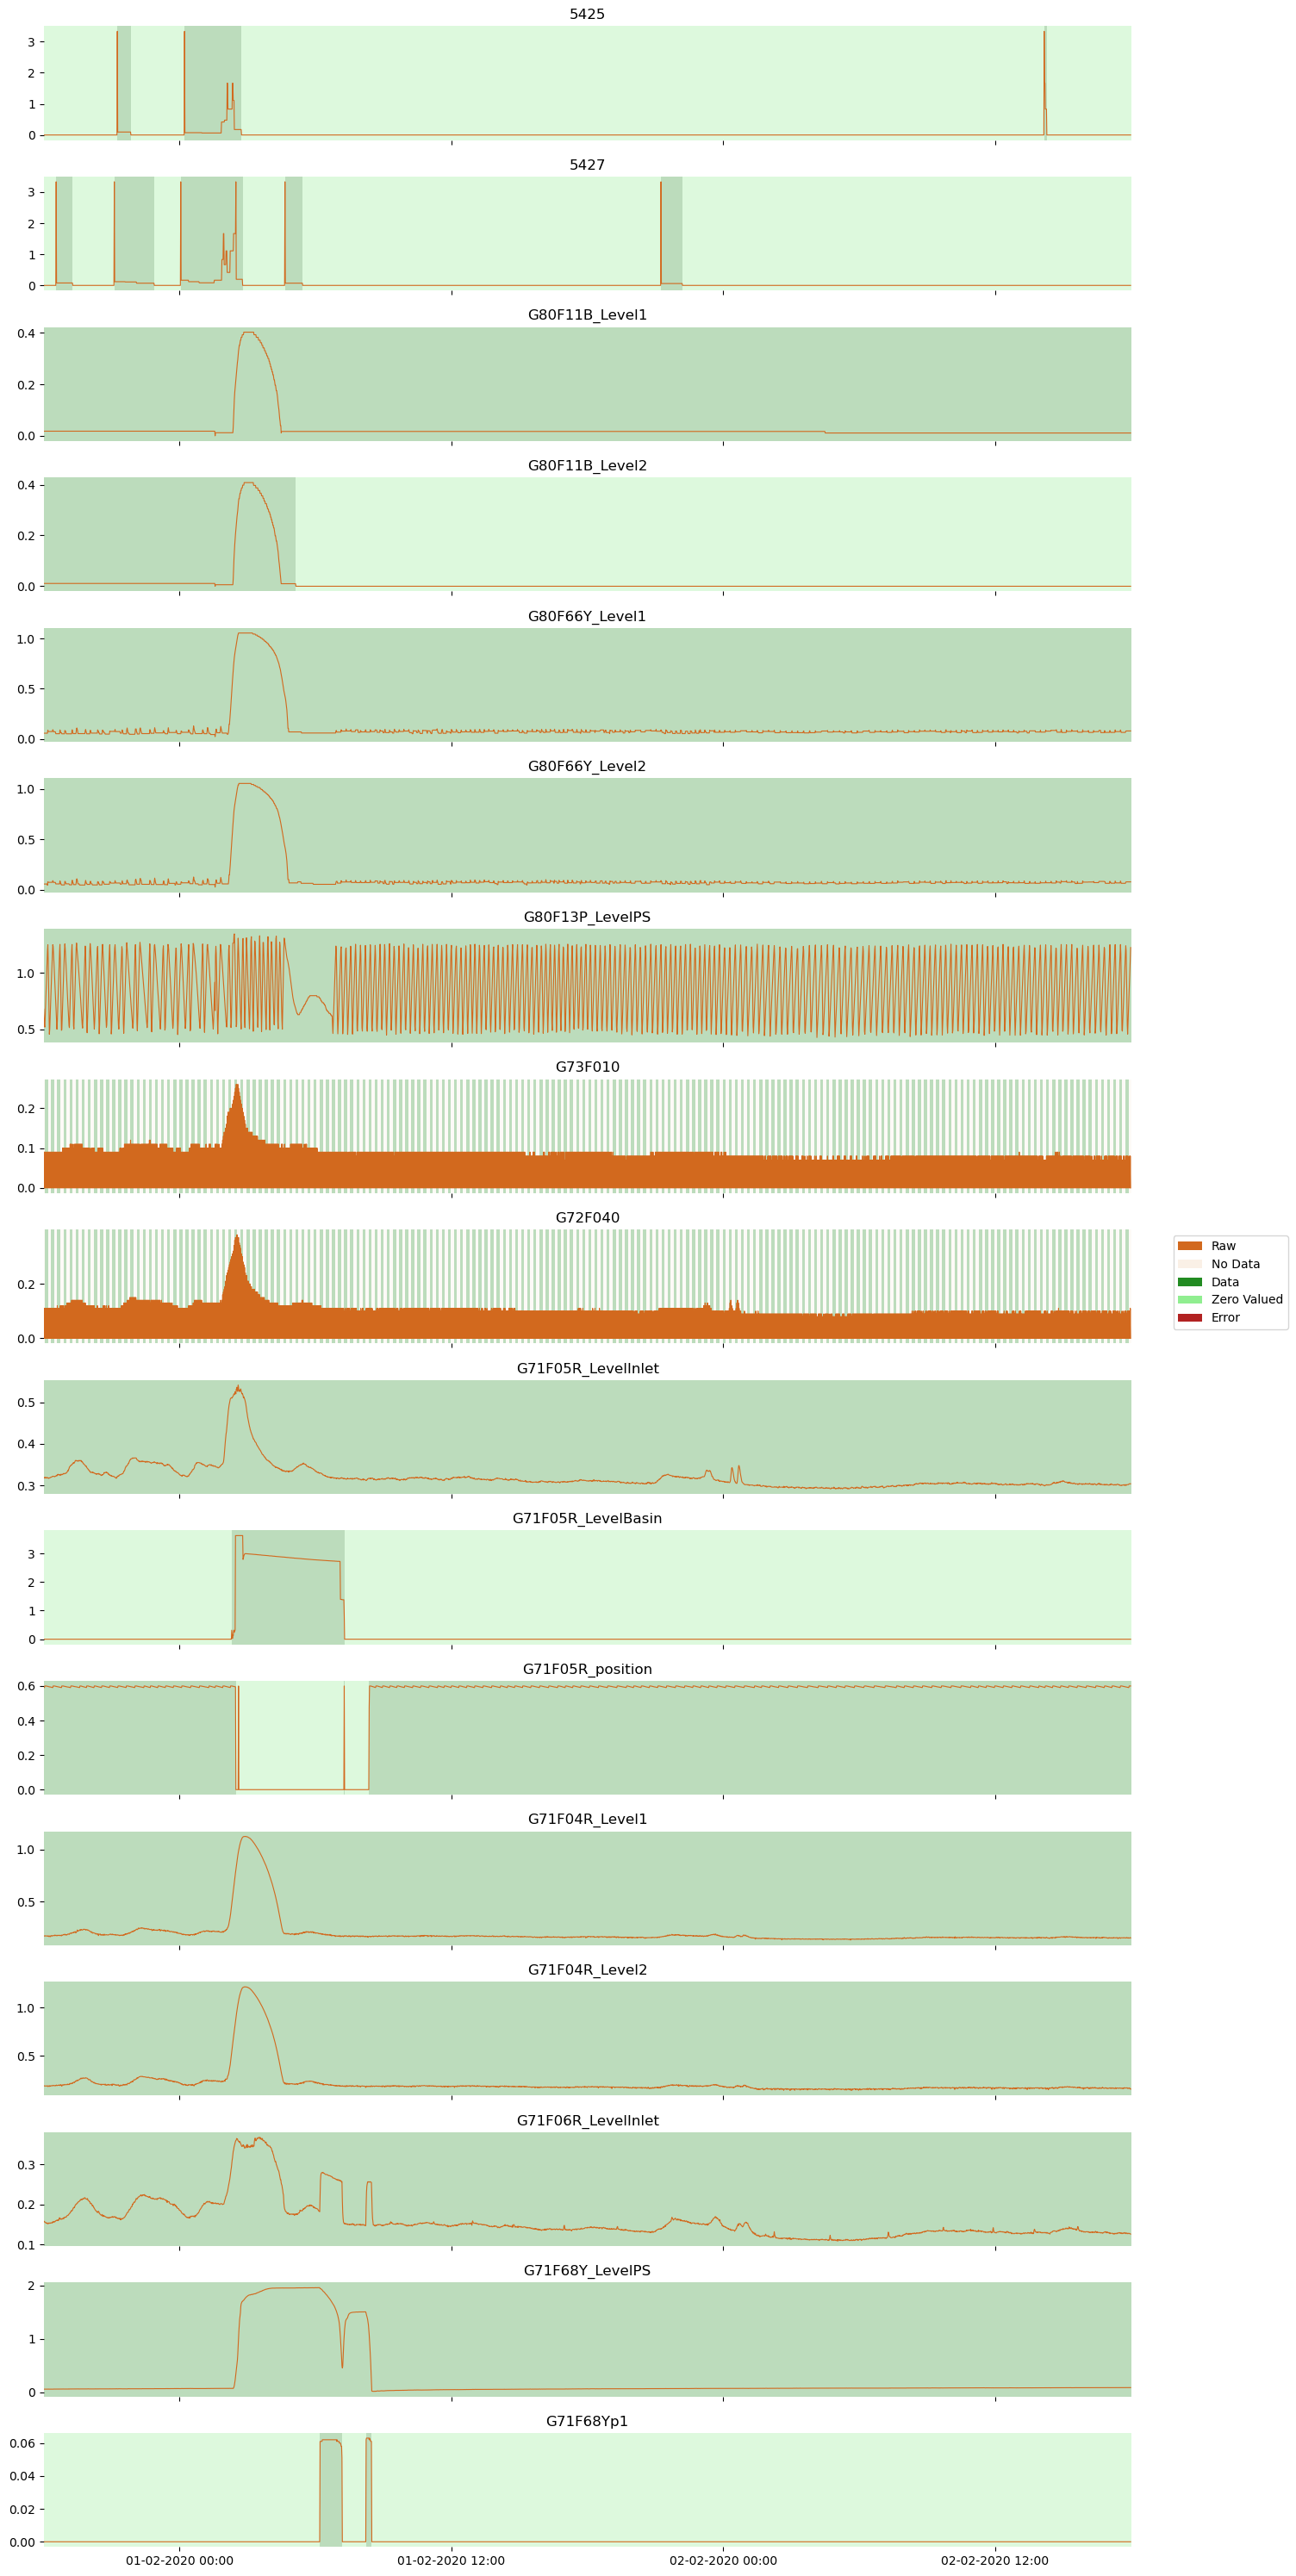

In [13]:
# Create a figure and axis for each column
fig, axs = plt.subplots(raw_event.shape[1], 1, figsize=(15, 30), sharex=True)

# Iterate over the columns and visualize the data
for i, column in enumerate(raw_event.columns):
    # plot with visualize_series_with_error(ax, period_series, period_I, timestamps, error_indicators, indicator_2_color, name_2_color):
    axs[i] = visualize_series_with_error(axs[i], raw_event[column], I_event[:, i], timestamps_event, indicator_2_color, name_2_color) 
    axs[i].set_title(column)
    axs[i].set_xticks([])

legend_elements = [Patch(facecolor='chocolate', label='Raw')]
for k, v in name_2_color.items():
    legend_elements.append(Patch(facecolor=v, label=k))
# center ax idx
center_idx = len(axs) // 2
axs[center_idx].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

# set the x-axis ticks
axs[-1] = set_meaningful_xaxis_timestamps(axs[-1], timestamps_event)

plt.tight_layout()
plt.show()

Only focus on rainfall for 5425 and level sensors

In [17]:
level_cols = [col for col in raw_event.columns if 'level' in col.lower() or col in ['G73F010', 'G72F040']]
sub_columns = ['5425'] + level_cols

# extract from the subset
sub_raw = raw_event[sub_columns]
sub_is_error = is_error_event[sub_columns]
sub_no_data = no_data_event[sub_columns]
sub_I = I_event[:, [raw.columns.get_loc(col) for col in sub_columns]]
sub_timestamps = timestamps_event

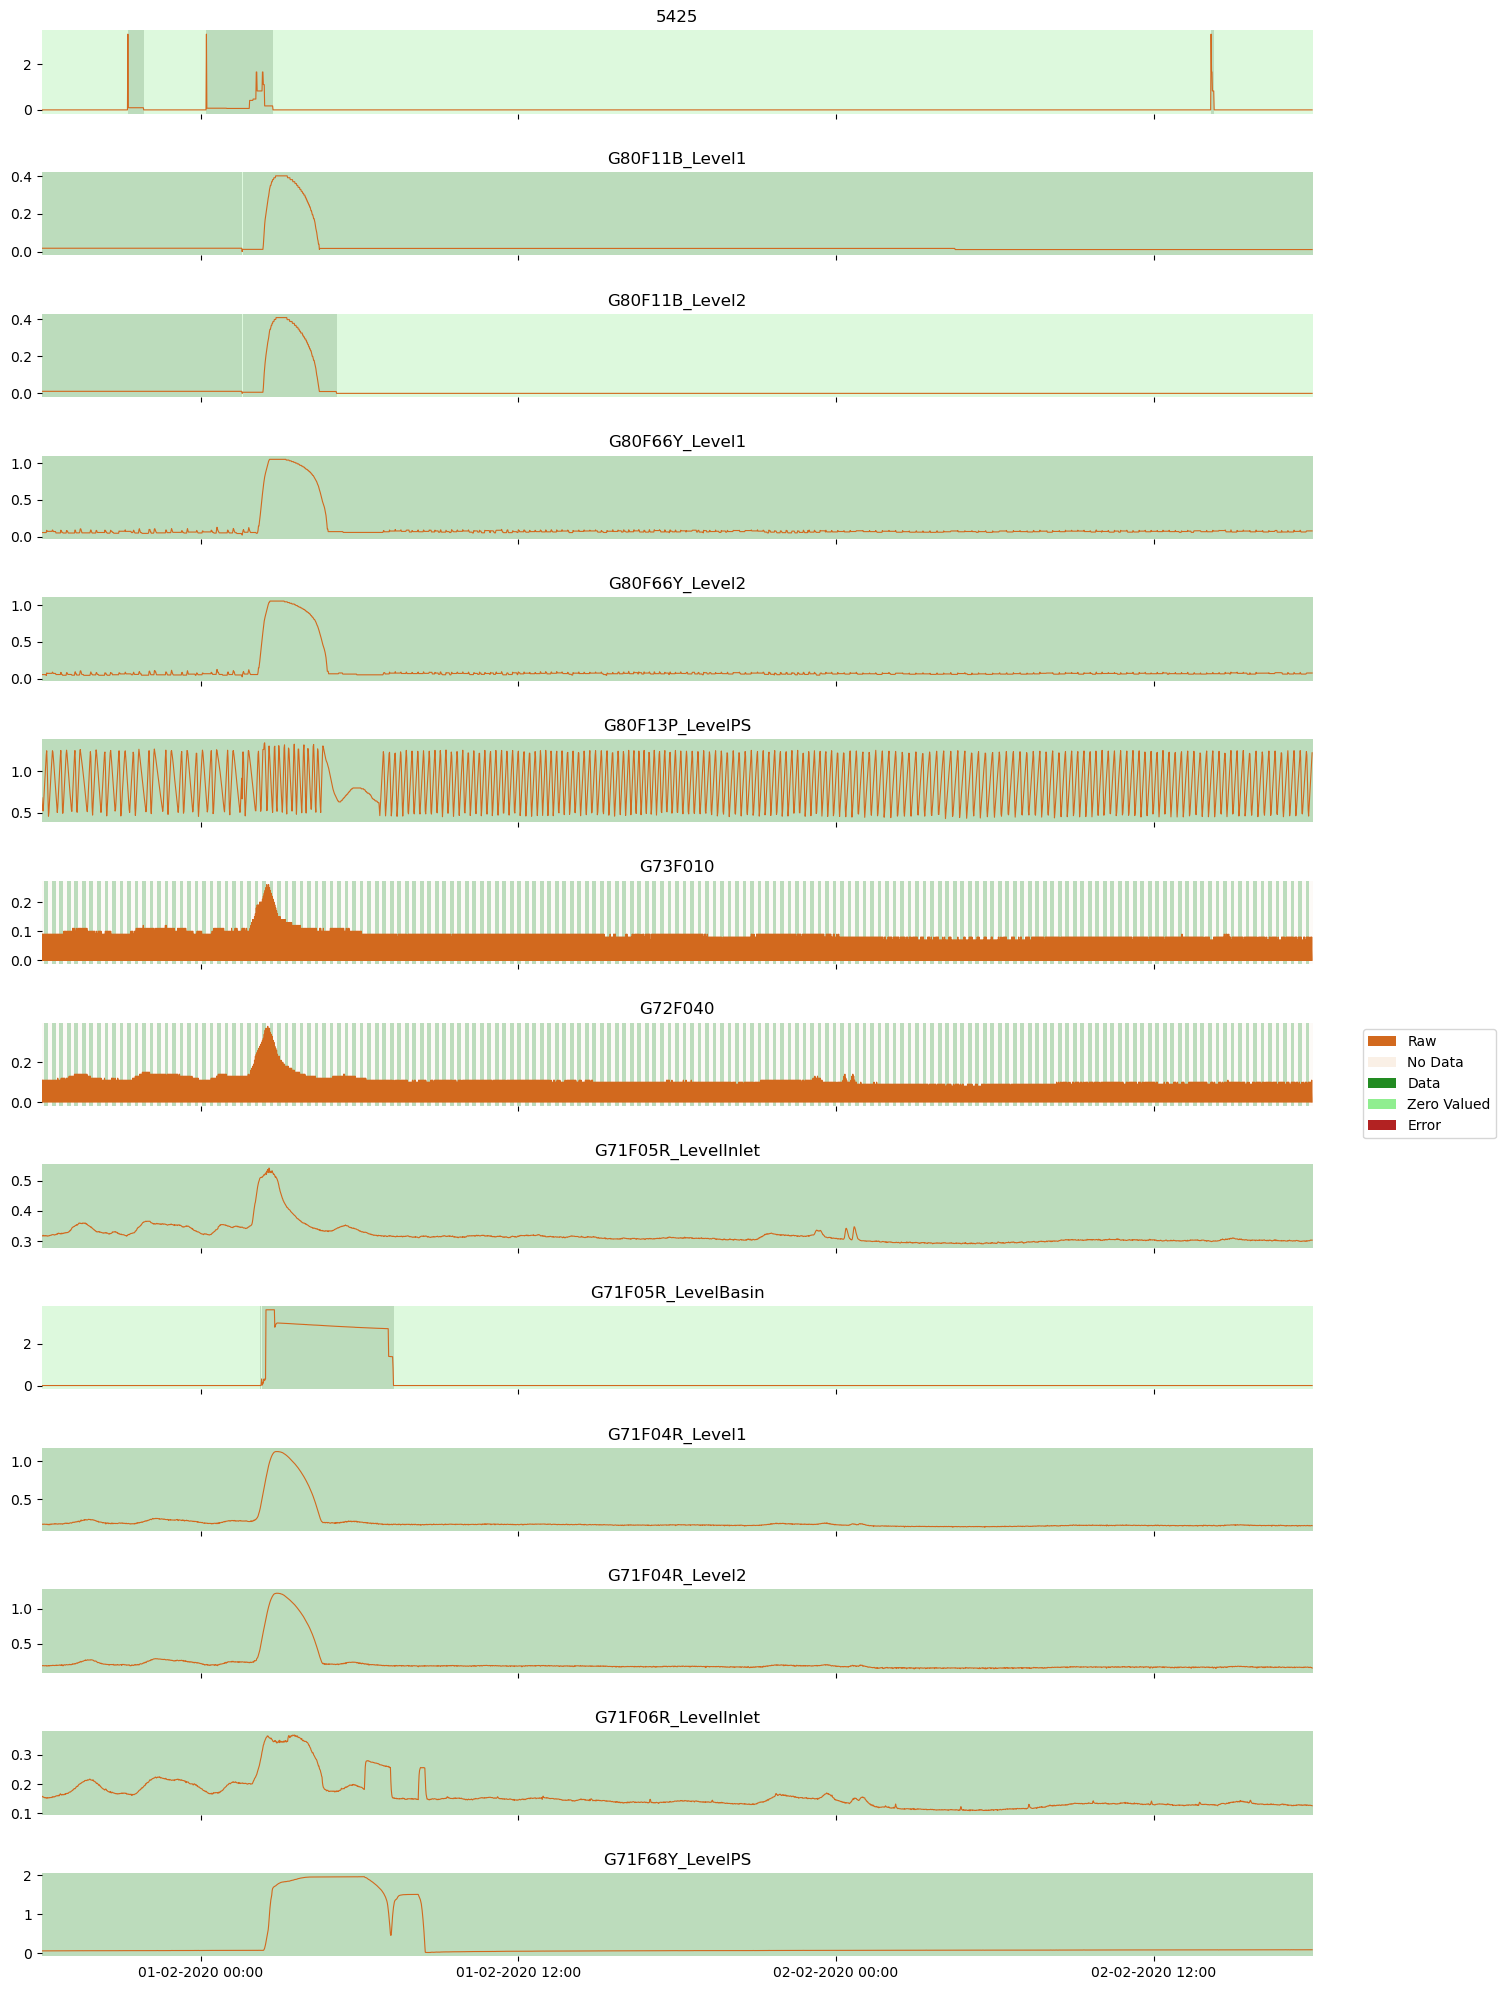

In [18]:
# Create a figure and axis for each column
fig, axs = plt.subplots(sub_raw.shape[1], 1, figsize=(15, 20), sharex=True)

# Iterate over the columns and visualize the data
for i, column in enumerate(sub_raw.columns):
    # plot with visualize_series_with_error(ax, period_series, period_I, timestamps, error_indicators, indicator_2_color, name_2_color):
    axs[i] = visualize_series_with_error(axs[i], sub_raw[column], sub_I[:, i], sub_timestamps, indicator_2_color, name_2_color) 
    axs[i].set_title(column)
    axs[i].set_xticks([])

legend_elements = [Patch(facecolor='chocolate', label='Raw')]
for k, v in name_2_color.items():
    legend_elements.append(Patch(facecolor=v, label=k))
# center ax idx
center_idx = len(axs) // 2
axs[center_idx].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

# set the x-axis ticks
axs[-1] = set_meaningful_xaxis_timestamps(axs[-1], timestamps_event)

plt.tight_layout()
plt.show()

In [19]:
# delete sub
del sub_raw, sub_is_error, sub_no_data, sub_I, sub_timestamps

#### Visualize structure wise

In [77]:
natural_structure_order

['G80F11B',
 'G80F66Y',
 'G80F13P',
 'G73F010',
 'G72F040',
 'G71F05R',
 'G71F04R',
 'G71F06R',
 'G71F68Y']

In [81]:
def visualize_structure_time_series(axs, raw_event, timestamps_event, natural_structure_order):

    # plotly
    #colors = [f'rgba({int(r*255)},{int(g*255)},{int(b*255)},1)' for r, g, b in plt.get_cmap('tab20')(np.linspace(0, 1, len(sub_raw.columns)))[:, :3]]
    # matplotlib
    colors = [f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for r, g, b in plt.get_cmap('tab20')(np.linspace(0, 1, len(raw_event.columns)))[:, :3]]
    # randomly sort the colors
    np.random.shuffle(colors)

    # assert that axes correspoonds to the structure
    assert len(natural_structure_order) == len(axs), "Number of structures does not match the number of axes"
    # iterate axs and natural_structure_order
    for i, (ax, structure) in enumerate(zip(axs, natural_structure_order)):
        structure = natural_structure_order[i]
        # extract the columns for the structure
        structure_cols = [col for col in raw_event.columns if structure in col]
        structure_raw = raw_event[structure_cols]
        # plot the series in the structure using the colors
        for j, column in enumerate(structure_raw.columns):
            h = raw_event.columns.get_loc(column)
            ax.plot(range(len(structure_raw)), structure_raw[column], color=colors[h], label=column, linewidth=0.8)
        # add legend, set structre as legend title
        ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1))#, title=structure)
        ax.set_title(structure)
        # set the x-axis ticks
        #ax = set_meaningful_xaxis_timestamps(axs[i], timestamps_event)

    return axs


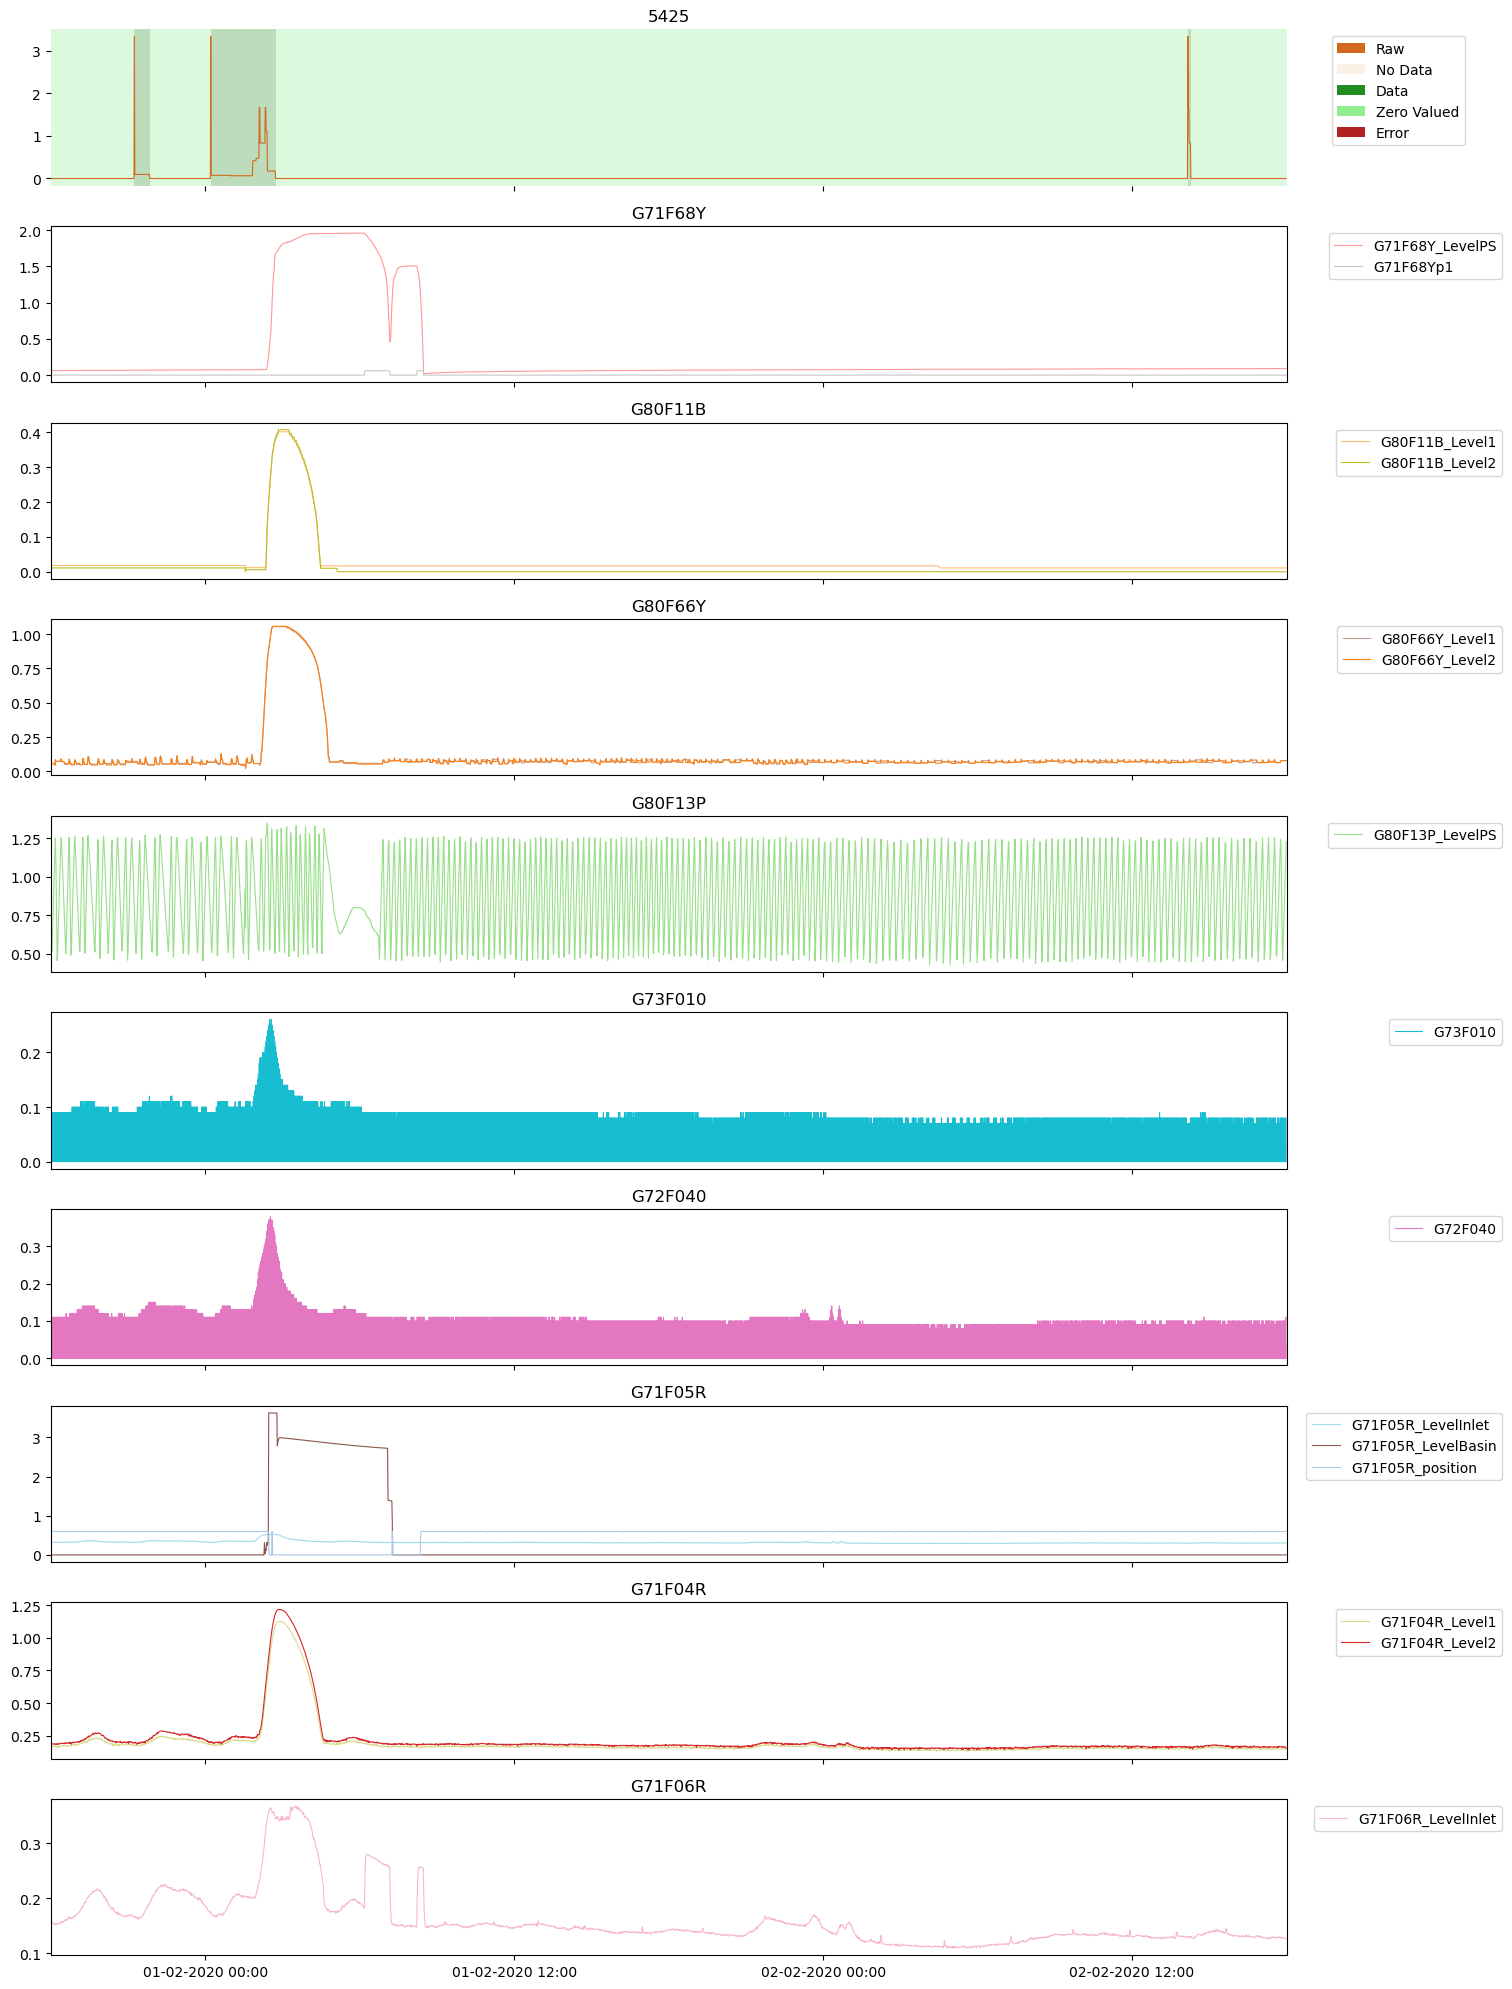

In [51]:

fig, axs = plt.subplots(len(natural_structure_order)+1, 1, figsize=(15, 20), sharex=True)
# visualize the rain
axs[0] = visualize_series_with_error(axs[0], raw_event['5425'], I_event[:, raw.columns.get_loc('5425')], timestamps_event, indicator_2_color, name_2_color)
legend_elements = [Patch(facecolor='chocolate', label='Raw')]
for k, v in name_2_color.items():
    legend_elements.append(Patch(facecolor=v, label=k))
axs[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))#, title='5425')
axs[0].set_title('5425')


# plotting structure wise
axs = visualize_structure_time_series(axs[1:], raw_event, timestamps_event, natural_structure_order)
plt.tight_layout()
plt.show()

## Rainfall events


classify rain events, each event can be defined as:
1. The event starts when the rain gauge is not zero
2. The event ends when the rain gauge is zero
3. The event has to be at least 30 minutes long
5. The event has to have at least 2 mm of rain in total
6. The event is 'relaxed' in case of zero gaps of 15 minutes

- there is a standard for this

In [100]:
def classify_rain_events(rain_series):
    # Thresholds
    min_event_duration = 30  # in minutes
    min_event_rainfall = 5  # in mm
    max_zero_gap = 15  # in minutes for relaxed events
    
    # Convert rain to a DataFrame with time as the index
    rain_data = rain_series.reset_index()  # Assumes 'time' is in the index if needed
    rain_data.columns = ['time', 'rain']
    
    # Ensure time is in datetime format if not already
    rain_data['time'] = pd.to_datetime(rain_data['time'])
    
    # Initialize variables for tracking events
    events = []
    current_event = []
    zero_streak = 0
    
    for i, row in tqdm(rain_data.iterrows(), total=len(rain_data), desc='Classifying rain events'):
        # Check if it's raining
        if row['rain'] > 0:
            if not current_event:
                current_event_start_time = row['time']
            current_event.append(row)
            zero_streak = 0  # Reset zero streak since it's raining
        elif row['rain'] == 0 and current_event:
            zero_streak += 1
            if zero_streak <= max_zero_gap:
                current_event.append(row)
            else:
                # End event before the zero streak starts
                event_end_time = current_event[-(zero_streak)].get('time')
                
                # Convert current_event to DataFrame
                event_df = pd.DataFrame(current_event)
                event_duration = (event_df['time'].max() - event_df['time'].min()).total_seconds() / 60.0
                total_rain = event_df['rain'].sum()
                
                if event_duration >= min_event_duration and total_rain >= min_event_rainfall:
                    events.append({
                        'start': current_event_start_time,
                        'end': event_end_time,
                        'duration': event_duration,
                        'total_rain': total_rain
                    })
                
                # Reset current event and zero streak
                current_event = []
                zero_streak = 0
    
    # After looping, check if there’s a valid ongoing event
    if current_event:
        event_df = pd.DataFrame(current_event)
        event_duration = (event_df['time'].max() - event_df['time'].min()).total_seconds() / 60.0
        total_rain = event_df['rain'].sum()
        if event_duration >= min_event_duration and total_rain >= min_event_rainfall:
            events.append({
                'start': current_event_start_time,
                'end': event_df['time'].max(),
                'duration': event_duration,
                'total_rain': total_rain
            })
        
    # create an intensity column
    events = pd.DataFrame(events)
    events['intensity'] = events['total_rain'] / events['duration']
    
    return events


In [292]:

def classify_rain_events(rain_series):
    # Thresholds
    min_event_duration = 30  # in minutes
    min_event_rainfall = 5  # in mm
    max_zero_gap = 15  # in minutes for relaxed events
    
    # Convert rain to a DataFrame with time as the index (assuming your index is time-based)
    rain_data = rain_series.reset_index()  # Ensuring that we have a proper time index
    rain_data.columns = ['time', 'rain']
    
    # Initialize variables for tracking events
    events = [] # List to store the events
    current_event = [] # List to store the current ongoing event
    zero_streak = 0 # Counter for the number of zero values
    
    for i, row in tqdm(rain_data.iterrows(), total=len(rain_data), desc='Classifying rain events'):
        # Check if it's raining
        if row['rain'] > 0:
            # If there's no ongoing event, start a new one
            if not current_event:
                current_event_start_time = row['time']
            current_event.append(row)
            zero_streak = 0  # Reset zero streak since it's raining
            
        # Check if it's not raining
        elif row['rain'] == 0 and current_event:
            zero_streak += 1  # Increase zero streak
            if zero_streak <= max_zero_gap:
                # Still within the relaxed gap period, consider it part of the event
                current_event.append(row)
            else:
                # Zero streak exceeds allowed gap, event ends here, but take the before the zero streak
                event_end_time = rain_data.loc[i - zero_streak, 'time']
                
                # Create a DataFrame for the event and apply filtering
                event_df = pd.DataFrame(current_event)
                event_duration = (event_df['time'].max() - event_df['time'].min()).total_seconds() / 60.0  # in minutes
                total_rain = event_df['rain'].sum()
                
                # Check if the event meets the criteria
                if event_duration >= min_event_duration and total_rain >= min_event_rainfall:
                    events.append({
                        'start': current_event_start_time,
                        'end': event_end_time,
                        'duration': event_duration,
                        'total_rain': total_rain
                    })
                
                # Reset the current event tracking
                current_event = []
                zero_streak = 0

    # After looping, check if there's a valid ongoing event
    if current_event:
        event_df = pd.DataFrame(current_event)
        event_duration = (event_df['time'].max() - event_df['time'].min()).total_seconds() / 60.0
        total_rain = event_df['rain'].sum()
        if event_duration >= min_event_duration and total_rain >= min_event_rainfall:
            events.append({
                'start': current_event_start_time,
                'end': event_df['time'].max(),
                'duration': event_duration,
                'total_rain': total_rain
            })
    
    return pd.DataFrame(events)


In [32]:
# get the rain series
rain = raw['5425'] # unit is mm/minute
rain_events = classify_rain_events(rain)

Classifying rain events: 100%|██████████| 6117121/6117121 [01:38<00:00, 62368.62it/s]


In [33]:
print(f"Found {len(rain_events)} rain events")
rain_events.head(3)

Found 2531 rain events


,start,end,duration,total_rain
0,2010-01-04 23:29:00,2010-01-05 00:28:00,74.0,6.637
1,2010-01-11 18:37:00,2010-01-12 03:12:00,530.0,123.296
2,2010-01-27 13:53:00,2010-01-27 16:17:00,159.0,36.689


In [34]:
I_rain = np.zeros_like(rain)
for _, event in tqdm(rain_events.iterrows(), total=len(rain_events), desc='Creating rain event indicator'):
    start_idx = timestamps_df[timestamps_df['time'] == event['start']].index[0]
    end_idx = timestamps_df[timestamps_df['time'] == event['end']].index[0]
    I_rain[start_idx:end_idx] = 1


Creating rain event indicator: 100%|██████████| 2531/2531 [00:44<00:00, 56.94it/s]


In [35]:
rain_indicator_metadata = {
    # Plotting order
    'No Rain': {
        'color': 'linen',
        'value': 0
    },
    'Rain': {
        'color': 'lightskyblue',
        'value': 1
    },
}

# create the index to color mapping
rain_indicator_2_color = {v['value']: v['color'] for k, v in rain_indicator_metadata.items()}
rain_indicator_2_name = {v['value']: k for k, v in rain_indicator_metadata.items()}
rain_name_2_color = {k: v['color'] for k, v in rain_indicator_metadata.items()}
rain_color_2_name = {v['color']: k for k, v in rain_indicator_metadata.items()}


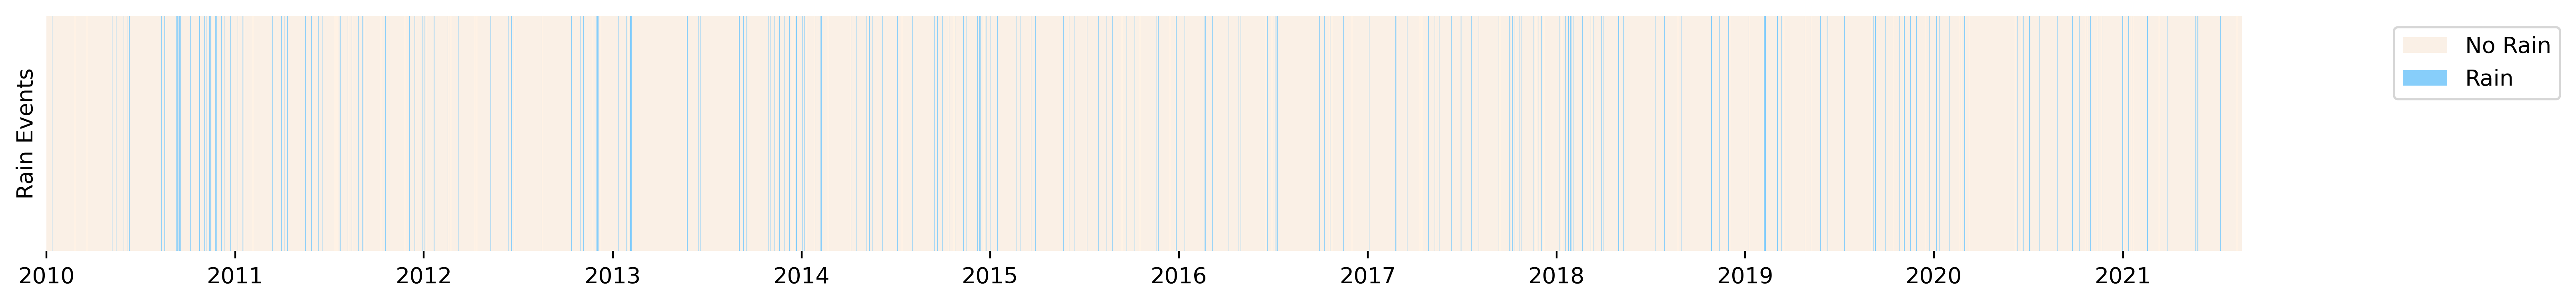

In [38]:
visualize_single_timeline(I_rain, timestamps_df, "Rain Events", rain_indicator_2_color, rain_name_2_color, figsize=(16, 2))

- There are some extreme events we can analyse

In [94]:
# visualize a rain event
single_rain_event = rain_events.iloc[500]
starttime = single_rain_event['start'] - pd.Timedelta(minutes=30)
endtime = single_rain_event['end'] + pd.Timedelta(minutes=120)
raw_event, is_error_event, no_data_event, I_event, timestamps_event = get_combined_event(raw, is_error, no_data, I, timestamps_df, starttime, endtime)

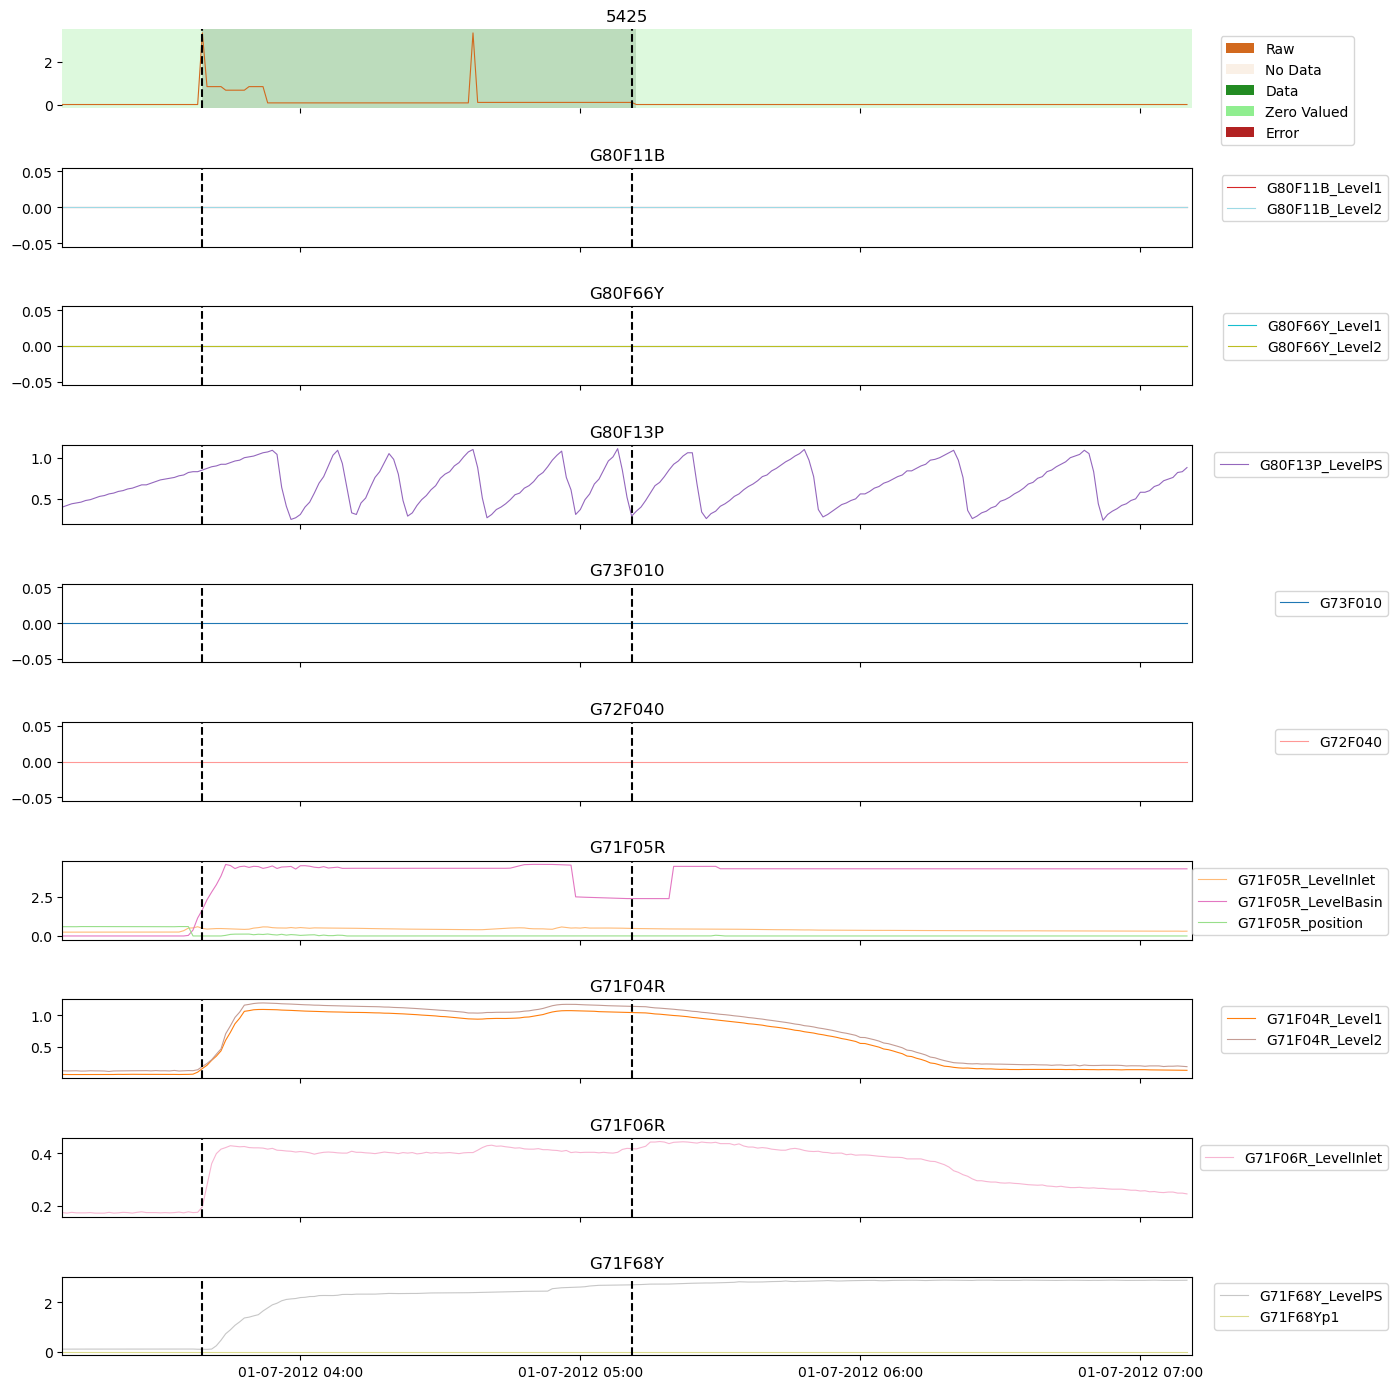

In [95]:

fig, axs = plt.subplots(len(natural_structure_order)+1, 1, figsize=(14, 14), sharex=True)
# visualize the rain
axs[0] = visualize_series_with_error(axs[0], raw_event['5425'], I_event[:, raw.columns.get_loc('5425')], timestamps_event, indicator_2_color, name_2_color)
legend_elements = [Patch(facecolor='chocolate', label='Raw')]
for k, v in name_2_color.items():
    legend_elements.append(Patch(facecolor=v, label=k))
axs[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))#, title='5425')
axs[0].set_title('5425')
# plotting structure wise
axs[1:] = visualize_structure_time_series(axs[1:], raw_event, timestamps_event, natural_structure_order)
# add start and end of the rain event to every axis
for ax in axs:
    ax.axvline(timestamps_event[timestamps_event['time'] == single_rain_event['start']].index[0], color='black', linestyle='--')
    ax.axvline(timestamps_event[timestamps_event['time'] == single_rain_event['end']].index[0], color='black', linestyle='--')

axs[-1] = set_meaningful_xaxis_timestamps(axs[-1], timestamps_event)
plt.tight_layout()
plt.show()

- can take an effect 2 hours after the event
- the first level sensor don't seem to respond

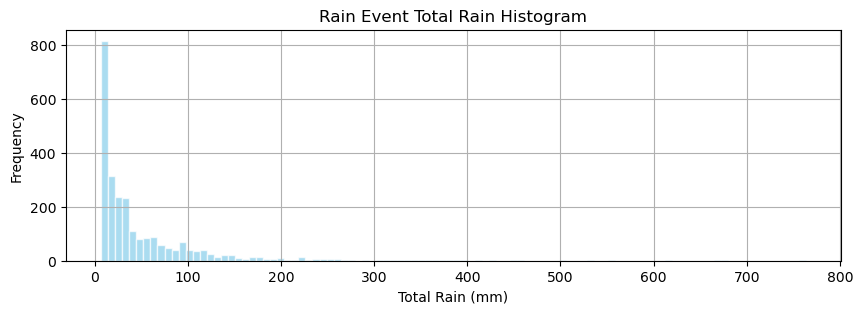

In [103]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
rain_events.total_rain.hist(bins=100, ax=ax, color='skyblue', alpha=0.7, edgecolor='white')
ax.set_title('Rain Event Total Rain Histogram')
ax.set_xlabel('Total Rain (mm)')
ax.set_ylabel('Frequency')
plt.show()

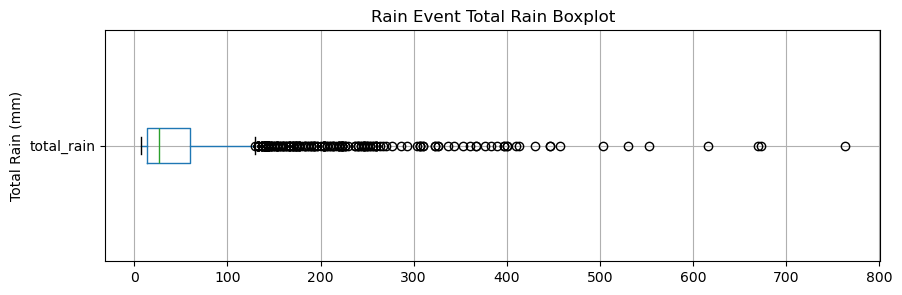

In [125]:
# Create a boxplot of the intensity of rain events, matplotlib
fig, ax = plt.subplots(figsize=(10, 3))
rain_events.boxplot(column='total_rain', ax=ax, vert=False)
ax.set_title('Rain Event Total Rain Boxplot')
ax.set_ylabel('Total Rain (mm)')
plt.show()

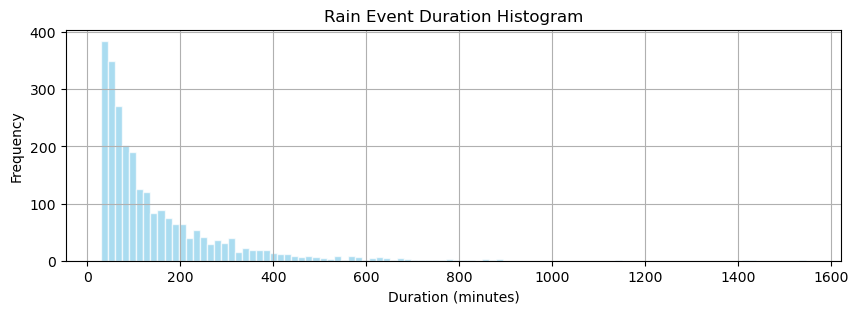

In [104]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
rain_events.duration.hist(bins=100, ax=ax, color='skyblue', alpha=0.7, edgecolor='white')
ax.set_title('Rain Event Duration Histogram')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Frequency')
plt.show()

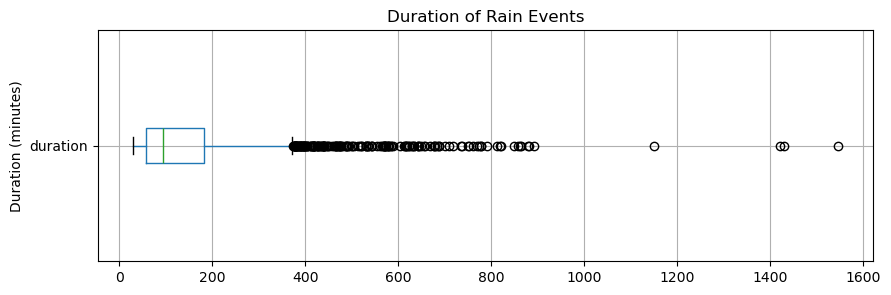

In [123]:
# Create a boxplot of the intensity of rain events, matplotlib
fig, ax = plt.subplots(figsize=(10, 3))
rain_events.boxplot(column='duration', ax=ax, vert=False)
ax.set_title('Duration of Rain Events')
ax.set_ylabel('Duration (minutes)')
plt.show()

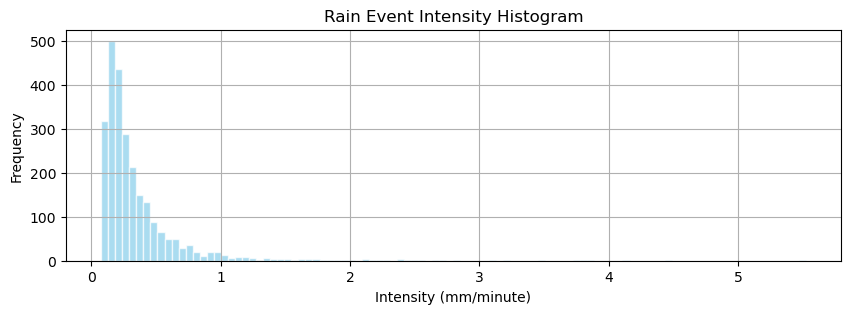

In [124]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
rain_events.intensity.hist(bins=100, ax=ax, color='skyblue', alpha=0.7, edgecolor='white')
ax.set_title('Rain Event Intensity Histogram')
ax.set_xlabel('Intensity (mm/minute)')
ax.set_ylabel('Frequency')
plt.show()

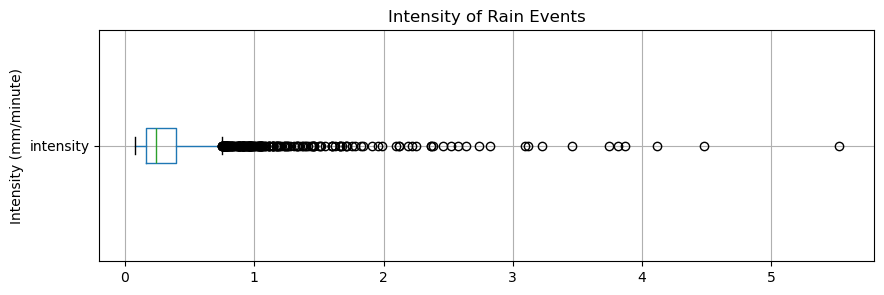

In [126]:
# Create a boxplot of the intensity of rain events, matplotlib
fig, ax = plt.subplots(figsize=(10, 3))
rain_events.boxplot(column='intensity', ax=ax, vert=False)
ax.set_title('Intensity of Rain Events')
ax.set_ylabel('Intensity (mm/minute)')
plt.show()

- There are some extreme event

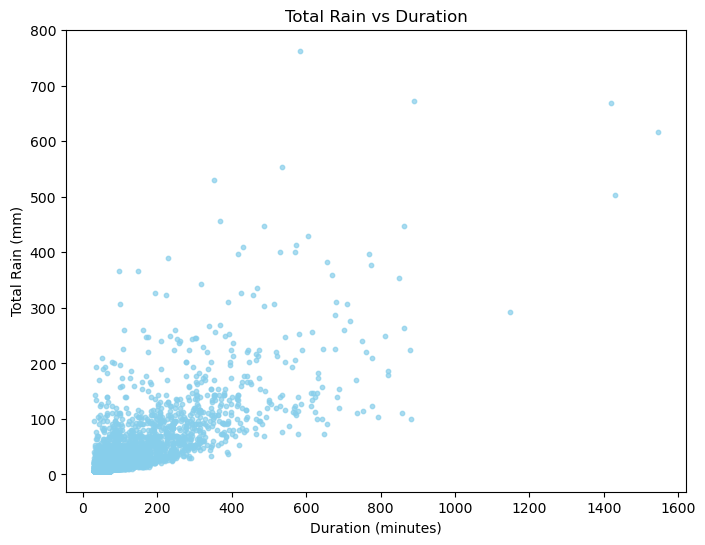

In [107]:
# scattter, total rain as a function of duration
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.scatter(rain_events.duration, rain_events.total_rain, color='skyblue', alpha=0.7, s=10)
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Total Rain (mm)')
ax.set_title('Total Rain vs Duration')
plt.show()

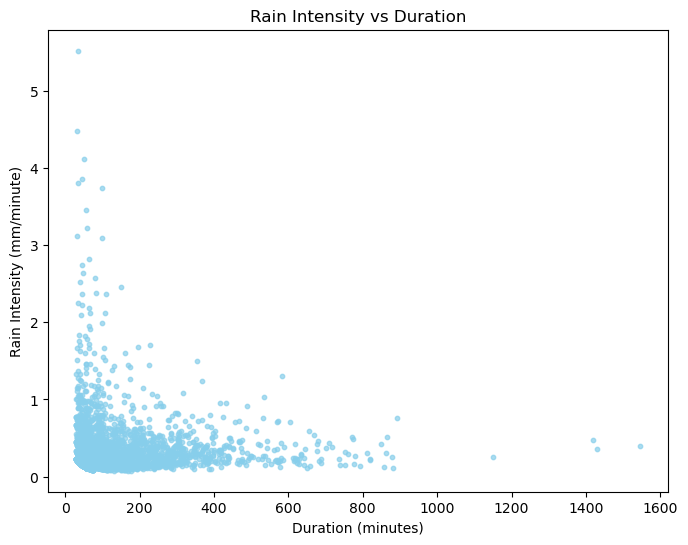

In [110]:
# scattter, total rain as a function of duration
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.scatter(rain_events.duration, rain_events.intensity, color='skyblue', alpha=0.7, s=10)
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Rain Intensity (mm/minute)')
ax.set_title('Rain Intensity vs Duration')
plt.show()

- this is typically a power law distribution, i.e. the rain intensity is higher for shorter

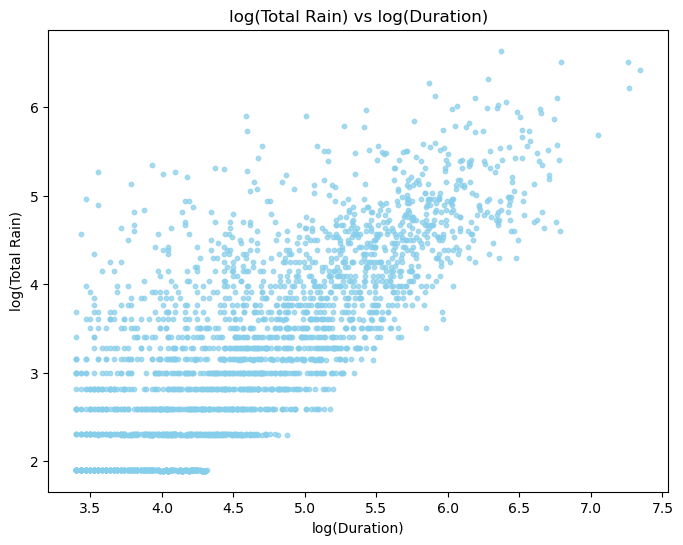

In [111]:
# for powerlaw, we can take the log of the data, i.e. log-log plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.scatter(np.log(rain_events.duration), np.log(rain_events.total_rain), color='skyblue', alpha=0.7, s=10)
ax.set_xlabel('log(Duration)')
ax.set_ylabel('log(Total Rain)')
ax.set_title('log(Total Rain) vs log(Duration)')
plt.show()

## System Response Time

- form rainfall start and until sensor values increase
    - combined only level
    - how to define change?

In [265]:
# for each train event start time, check when sensor values start to increase
# - until not intervened by another rain event or 1 hour has passed
# - if the sensor values start to increase, then the rain event is considered to have caused the increase
# - base the increase on the first 5 minutes of the rain event


def get_system_response_time(rain_events, raw, timestamps_df, level_cols):

    pre_event_period = 30  # in minutes, maximum time to check for pre-event data
    post_event_period = 180  # in minutes, maximum time to check for response, if not within the rain event

    raw = raw[level_cols].copy()

    # create a response time dataframe
    for level in level_cols:
        rain_events['response_time_' + level] = np.nan



    for i, event in tqdm(rain_events.iterrows(), total=len(rain_events), desc='Checking system response time'):
        start_idx = timestamps_df[timestamps_df['time'] == event['start']].index[0]
        end_idx = timestamps_df[timestamps_df['time'] == event['end']].index[0]
        
        # get the 10 minute pre-event data maximum for each sensor
        pre_event_data = raw.iloc[start_idx-pre_event_period:start_idx]
        #pre_event_data = pre_event_data.max(axis=0)
        # take the upper 75% quantile
        #pre_event_data = pre_event_data.quantile(0.75, axis=0)
        pre_event_data = pre_event_data.max()
        # get the event data
        end_idx = end_idx if start_idx - end_idx > post_event_period else start_idx + post_event_period
        event_data = raw.iloc[start_idx:end_idx + post_event_period]

        # check when the event data starts to increase higher than the pre-event data
        for level in level_cols:
            level_data = event_data[level]
            pre_event_max = pre_event_data[level]

            # iterate until 1 hour has passed or the event ends
            for i in range(5, len(level_data)):
                if level_data[i] > pre_event_max:
                    response_time = timestamps_df.iloc[start_idx + i]['time']
                    # get the response time, minute based
                    time_until_response = (response_time - event['start']).total_seconds() / 60.0

                    # update the response time
                    rain_events.at[event.name, 'response_time_' + level] = time_until_response
                    break
                    
    return rain_events

In [266]:
# get the response time
rain_events = get_system_response_time(rain_events, raw, timestamps_df, level_cols)

Checking system response time: 100%|██████████| 2531/2531 [01:14<00:00, 34.08it/s]


In [267]:
response_time_cols = [col for col in rain_events.columns if 'response_time' in col]
len(response_time_cols)

13

In [268]:
# total nans for each
rain_events[response_time_cols].isna().sum()

response_time_G80F11B_Level1        2321
response_time_G80F11B_Level2        2285
response_time_G80F66Y_Level1        2119
response_time_G80F66Y_Level2        2118
response_time_G80F13P_LevelPS        249
response_time_G73F010               2037
response_time_G72F040               2445
response_time_G71F05R_LevelInlet     190
response_time_G71F05R_LevelBasin    1472
response_time_G71F04R_Level1        1754
response_time_G71F04R_Level2         392
response_time_G71F06R_LevelInlet     221
response_time_G71F68Y_LevelPS        395
dtype: int64

- Seems like some sensors don't really respond to the rain event
- But the response time can vary

In [269]:
scatterplotmatrix(rain_events[response_time_cols].values, figsize=(50, 40), names=response_time_cols, alpha=0.5)
# save the figure
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'response_time.png', dpi=300)
plt.close()

- 

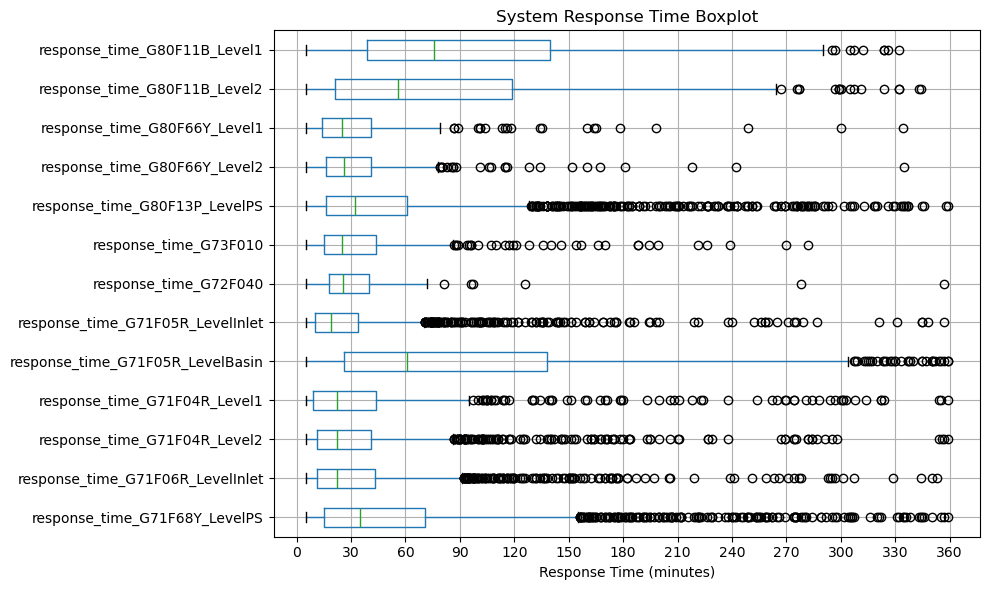

In [270]:
# visualize the response time as boxplots for each level
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
rain_events[response_time_cols].boxplot(ax=ax, vert=False)
ax.set_title('System Response Time Boxplot')
ax.set_xlabel('Response Time (minutes)')
# set xticks every 30 minutes
max_response_time = rain_events[response_time_cols].max().max()
ax.set_xticks(np.arange(0, max_response_time+30, 30))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

- sensors usually respond within the first 30 minutes
- late response time
    - The first level sensor respond so late?
    - The basin
    - And the pipes?
    - maybe Rocco can help explain this?



- normalize?
    - since e.g. basin width and make slower increse

In [145]:
rain_events.head(3) 

,start,end,duration,total_rain,intensity,response_time_G80F11B_Level1,response_time_G80F11B_Level2,response_time_G80F66Y_Level1,response_time_G80F66Y_Level2,response_time_G80F13P_LevelPS,response_time_G73F010,response_time_G72F040,response_time_G71F05R_LevelInlet,response_time_G71F05R_LevelBasin,response_time_G71F04R_Level1,response_time_G71F04R_Level2,response_time_G71F06R_LevelInlet,response_time_G71F68Y_LevelPS
0,2010-01-04 23:29:00,2010-01-05 00:28:00,74.0,6.637,0.089689,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-11 18:37:00,2010-01-12 03:12:00,530.0,123.296,0.232634,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-27 13:53:00,2010-01-27 16:17:00,159.0,36.689,0.230748,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## System Recovery Time

- until sensors reach what they were prior (combined and separate)
    - if not intervened by another rain event - then exclude
    - combined only level
    - more than 1 hour then ignore?


In [201]:
def get_system_recovery_time(rain_events, raw, timestamps_df, level_cols):
    # use the rain event response time to check when the system recovers
    #   - if nan, then exclude the event for the recovery time
    #   - system has recovered when it reaches the pre-event level
    
    # don't ierate more than
    max_recovery_time = 60*24*1


    raw = raw[level_cols].copy()
    # create a response time dataframe
    for level in level_cols:
        rain_events['recovery_time_' + level] = np.nan

    for i, event in tqdm(rain_events.iterrows(), total=len(rain_events), desc='Checking system recovery time'):
        start_idx = timestamps_df[timestamps_df['time'] == event['start']].index[0]
        end_idx = timestamps_df[timestamps_df['time'] == event['end']].index[0]
        
        # get the 10 minute pre-event data maximum for each sensor
        pre_event_data = raw.iloc[start_idx:end_idx]
        #pre_event_data = pre_event_data.max(axis=0)
        # take the upper 75% quantile
        pre_event_data = pre_event_data.quantile(0.75, axis=0)

        # In this case, we will not use an end time, but rather check when the system has recovered
        for level in level_cols:
            level_response_time = 'response_time_' + level
            # check if the response time is nan
            if np.isnan(event[level_response_time]):
                continue
            # get the response time index
            level_response_index = timestamps_df[timestamps_df['time'] == event['start'] + pd.Timedelta(minutes=event[level_response_time])].index[0]
            level_end_index = timestamps_df[timestamps_df['time'] == event['end']].index[0]
            # start from the max of the response time and the end time
            search_start_index = max(level_response_index, level_end_index)
            # get the recovery threshold based on the pre-event data
            recovery_threshold = pre_event_data[level]
            # find the the first time the system recovers
            for i in range(search_start_index, len(raw)):
                # ensure the window is valid for computing averages
                if i - level_response_index > max_recovery_time:
                    break
                # use the 5 min average
                average = raw.iloc[i-5:i][level].mean()
                # if sensor is 0 then skip
                if raw.iloc[i][level] == 0:
                    continue    
                # check if the average has recovered based on the pre-event data
                if average <= recovery_threshold:
                    recovery_time = timestamps_df.iloc[i]['time']
                    time_until_recovery = (recovery_time - event['end']).total_seconds() / 60.0
                    rain_events.at[event.name, 'recovery_time_' + level] = time_until_recovery
                    break

    return rain_events


In [247]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_system_recovery_time(rain_events, raw, timestamps_df, level_cols):
    """
    Determines system recovery time after rain events. 
    If a system returns to pre-event level, it records the recovery time in the rain_events dataframe.
    
    Parameters:
    - rain_events: DataFrame containing event start, end, and response times.
    - raw: DataFrame with raw sensor level data.
    - timestamps_df: DataFrame containing a 'time' column with timestamps.
    - level_cols: List of column names in `raw` representing the different sensor levels.
    
    Returns:
    - Updated rain_events DataFrame with new 'recovery_time_*' columns.
    """
    max_recovery_time = 60 * 24  # 24 hours in minutes

    raw = raw[level_cols].copy()

    # Initialize recovery_time columns for each level with NaN
    for level in level_cols:
        rain_events['recovery_time_' + level] = np.nan

    for i, event in tqdm(rain_events.iterrows(), total=len(rain_events), desc='Checking system recovery time'):
        try:
            start_idx = timestamps_df[timestamps_df['time'] == event['start']].index[0]
            end_idx = timestamps_df[timestamps_df['time'] == event['end']].index[0]
        except IndexError:
            # Handle cases where start or end time is not found in timestamps_df
            continue

        # Get pre-event data: 10 minutes before the start of the event
        pre_event_window = timestamps_df.loc[max(0, start_idx - 10):start_idx]
        pre_event_data = raw.loc[pre_event_window.index]
        pre_event_data = pre_event_data.quantile(0.75, axis=0)  # Use the upper 75% quantile

        # For each sensor level, check recovery time
        for level in level_cols:
            level_response_time = 'response_time_' + level
            if np.isnan(event[level_response_time]):
                continue

            try:
                # Get the response time index
                level_response_index = timestamps_df[timestamps_df['time'] == event['start'] + pd.Timedelta(minutes=event[level_response_time])].index[0]
            except IndexError:
                # Handle cases where response time is not found
                continue
            
            # Start searching from the max of response time or event end
            search_start_index = max(level_response_index, end_idx)
            recovery_threshold = pre_event_data[level]  # Recovery threshold based on pre-event data
            
            # Search for recovery within a time window
            search_end_index = min(search_start_index + max_recovery_time, len(raw))
            for idx in range(search_start_index, search_end_index):
                if idx < 5:  # Ensure a valid window for 5-min averaging
                    continue
                
                # 5-minute moving average for recovery check
                window_data = raw.iloc[idx-5:idx][level]
                average = window_data.mean()
                
                # If the sensor level is zero, skip the entry
                if raw.iloc[idx][level] == 0:
                    continue
                
                # If the average is less than or equal to the recovery threshold, system has recovered
                if average <= recovery_threshold:
                    recovery_time = timestamps_df.iloc[idx]['time']
                    time_until_recovery = (recovery_time - event['end']).total_seconds() / 60.0
                    rain_events.at[event.name, 'recovery_time_' + level] = time_until_recovery
                    break

    return rain_events


In [256]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_system_recovery_time(rain_events, raw, timestamps_df, level_cols):
    max_recovery_time = 60 * 24  # 24 hours in minutes

    raw = raw[level_cols].copy()

    # Initialize recovery_time columns for each level with NaN
    for level in level_cols:
        rain_events['recovery_time_' + level] = np.nan

    for i, event in tqdm(rain_events.iterrows(), total=len(rain_events), desc='Checking system recovery time'):
        start_time = event['start']
        end_time = event['end']
        # Find the start and end indices based on the time values
        start_idx = timestamps_df[timestamps_df['time'] == start_time].index[0]
        end_idx = timestamps_df[timestamps_df['time'] == end_time].index[0]

        # Use the time column to find pre-event data 10 minutes before the event
        pre_event_start_index = start_idx - 10
        pre_event_data = raw.iloc[pre_event_start_index:start_idx]
        
        # Take the 75th percentile of the pre-event data for each level
        pre_event_data = pre_event_data.quantile(0.75, axis=0)

        # For each sensor level, check recovery time
        for level in level_cols:
            level_response_time = 'response_time_' + level
            if np.isnan(event[level_response_time]):
                continue

            try:
                # Get the response time index
                response_time = start_time + pd.Timedelta(minutes=event[level_response_time])
                level_response_index = timestamps_df[timestamps_df['time'] == response_time].index[0]
            except IndexError:
                # Handle cases where response time is not found
                continue

            # Start searching from the max of response time or event end
            search_start_index = max(level_response_index, end_idx)
            recovery_threshold = pre_event_data[level]  # Recovery threshold based on pre-event data
            
            # Search for recovery within a time window
            search_end_index = min(search_start_index + max_recovery_time, len(raw))
            for idx in range(search_start_index, search_end_index):
                if idx < 5:  # Ensure a valid window for 5-min averaging
                    continue
                
                # 5-minute moving average for recovery check
                window_data = raw.iloc[idx-5:idx][level]
                average = window_data.mean()
                
                # If the sensor level is zero, skip the entry
                if raw.iloc[idx][level] == 0:
                    continue
                
                # If the average is less than or equal to the recovery threshold, system has recovered
                if average <= recovery_threshold:
                    recovery_time = timestamps_df.iloc[idx]['time']
                    time_until_recovery = (recovery_time - event['end']).total_seconds() / 60.0
                    rain_events.at[event.name, 'recovery_time_' + level] = time_until_recovery
                    break

    return rain_events


In [257]:
rain_events = get_system_recovery_time(rain_events, raw, timestamps_df, level_cols)

Checking system recovery time: 100%|██████████| 2531/2531 [06:46<00:00,  6.23it/s]


In [258]:
recovery_time_cols = [col for col in rain_events.columns if 'recovery_time' in col]
len(recovery_time_cols)

13

In [259]:
# total nans for each
rain_events[recovery_time_cols].isna().sum()

recovery_time_G80F11B_Level1        2414
recovery_time_G80F11B_Level2        2337
recovery_time_G80F66Y_Level1        2137
recovery_time_G80F66Y_Level2        2136
recovery_time_G80F13P_LevelPS         73
recovery_time_G73F010               2019
recovery_time_G72F040               2445
recovery_time_G71F05R_LevelInlet     314
recovery_time_G71F05R_LevelBasin    1576
recovery_time_G71F04R_Level1        1803
recovery_time_G71F04R_Level2         472
recovery_time_G71F06R_LevelInlet     359
recovery_time_G71F68Y_LevelPS        806
dtype: int64

In [261]:
scatterplotmatrix(rain_events[recovery_time_cols].values, figsize=(50, 40), names=response_time_cols, alpha=0.5)
# save the figure
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'recovery_time.png', dpi=300)
plt.close()

- 

In [262]:
rain_events[recovery_time_cols].max().max()

1439.0

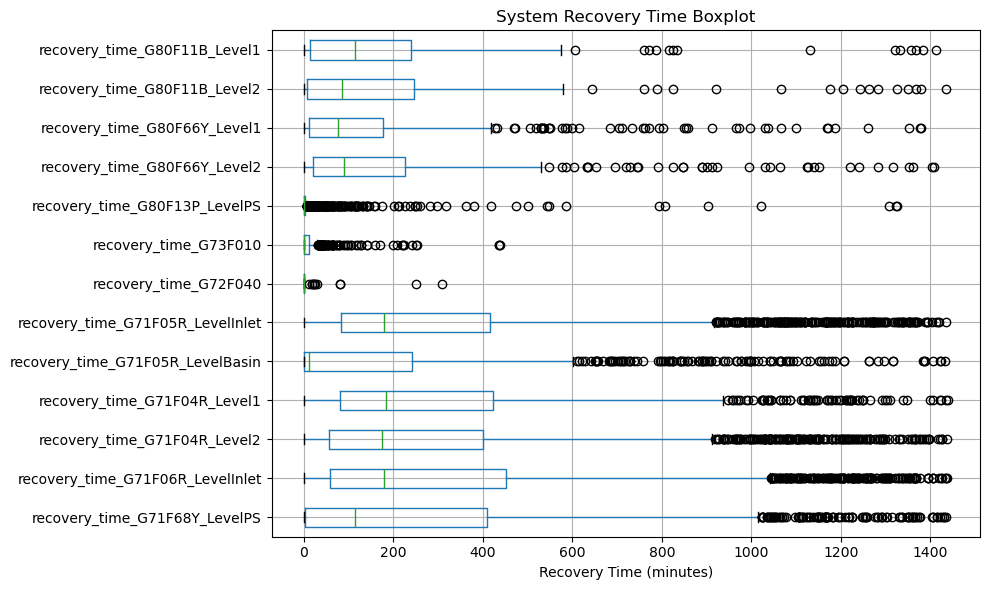

In [260]:
# visualize the response time as boxplots for each level
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
rain_events[recovery_time_cols].boxplot(ax=ax, vert=False)
ax.set_title('System Recovery Time Boxplot')
ax.set_xlabel('Recovery Time (minutes)')
# # set xticks every 30 minutes
#max_recovery_time = rain_events[recovery_time_cols].max().max()
# ax.set_xticks(np.arange(0, max_recovery_time+30, 30))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

- It all seems very low so probably not working?

#### Visualize event

In [237]:
# visualize a rain event
single_rain_event = rain_events.iloc[600]
starttime = single_rain_event['start'] - pd.Timedelta(minutes=30)
# get max recovery time
max_recovery_time = rain_events[recovery_time_cols].max().max()
endtime = single_rain_event['end'] + pd.Timedelta(minutes=max_recovery_time)
#endtime = single_rain_event['end'] + pd.Timedelta(minutes=120)
raw_event, is_error_event, no_data_event, I_event, timestamps_event = get_combined_event(raw, is_error, no_data, I, timestamps_df, starttime, endtime)

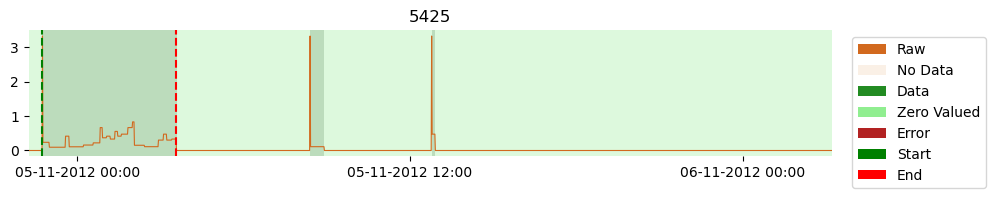

In [271]:

fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
# visualize the rain
ax = visualize_series_with_error(ax, raw_event['5425'], I_event[:, raw.columns.get_loc('5425')], timestamps_event, indicator_2_color, name_2_color)
legend_elements = [Patch(facecolor='chocolate', label='Raw')]
for k, v in name_2_color.items():
    legend_elements.append(Patch(facecolor=v, label=k))
ax.set_title('5425')
ax.axvline(timestamps_event[timestamps_event['time'] == single_rain_event['start']].index[0], color='green', linestyle='--')
legend_elements.append(Patch(facecolor='green', label='Start'))
ax.axvline(timestamps_event[timestamps_event['time'] == single_rain_event['end']].index[0], color='red', linestyle='--')
legend_elements.append(Patch(facecolor='red', label='End'))
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1))#, title='5425')

ax = set_meaningful_xaxis_timestamps(ax, timestamps_event)
plt.tight_layout()
plt.show()

In [1]:
fig, axs = plt.subplots(len(natural_structure_order)+1, 1, figsize=(14, 14), sharex=True)
# visualize the rain
axs[0] = visualize_series_with_error(axs[0], raw_event['5425'], I_event[:, raw.columns.get_loc('5425')], timestamps_event, indicator_2_color, name_2_color)
legend_elements = [Patch(facecolor='chocolate', label='Raw')]
for k, v in name_2_color.items():
    legend_elements.append(Patch(facecolor=v, label=k))
axs[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))#, title='5425')
axs[0].set_title('5425')
# plotting structure wise
axs[1:] = visualize_structure_time_series(axs[1:], raw_event[level_cols], timestamps_event, natural_structure_order)
# add start and end of the rain event to every axis
for i, (ax, structure) in enumerate(zip(axs[1:], natural_structure_order)):
    ax.axvline(timestamps_event[timestamps_event['time'] == single_rain_event['start']].index[0], color='green', linestyle='--')
    ax.axvline(timestamps_event[timestamps_event['time'] == single_rain_event['end']].index[0], color='red', linestyle='--')
    # add the response time
    structure_level_cols = [col for col in level_cols if col in structure_2_sensor[structure]]
    for level in structure_level_cols:
        response_time = single_rain_event['response_time_' + level]
        if not np.isnan(response_time):
            ax.axvline(timestamps_event[timestamps_event['time'] == single_rain_event['start'] + pd.Timedelta(minutes=response_time)].index[0], color='blue', linestyle='--')
            #ax.text(timestamps_event[timestamps_event['time'] == single_rain_event['start'] + pd.Timedelta(minutes=response_time)].index[0], 0, "Response", rotation=90, verticalalignment='bottom')
        recovery_time = single_rain_event['recovery_time_' + level]
        if not np.isnan(recovery_time):
            ax.axvline(timestamps_event[timestamps_event['time'] == single_rain_event['end'] + pd.Timedelta(minutes=recovery_time)].index[0], color='orange', linestyle='--')
            #ax.text(timestamps_event[timestamps_event['time'] == single_rain_event['end'] + pd.Timedelta(minutes=recovery_time)].index[0], 0, "Recovered")#, rotation=90, verticalalignment='bottom')

axs[-1] = set_meaningful_xaxis_timestamps(axs[-1], timestamps_event)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

- use rupture?

In [284]:
from yellowbrick.regressor import AlphaSelection

In [287]:
series = raw_event['G71F68Y_LevelPS']

In [ ]:
import changefinder


In [ ]:
visualizer = AlphaSelection(RidgeCV(alphas=series))
visualizer.fit(X, y)
visualizer.show()

# TODO: use change point detection algorithm instead

### Extreme events?




### TODO:

- Time differences between peak rainfall and peak sewer values - levels


Plotting
- Pre
- Intra
- Post

Dry-Weather vs. Wet-Weather comparing
- E.g. seeing the average in-sewer levels


something with maximum capacity?

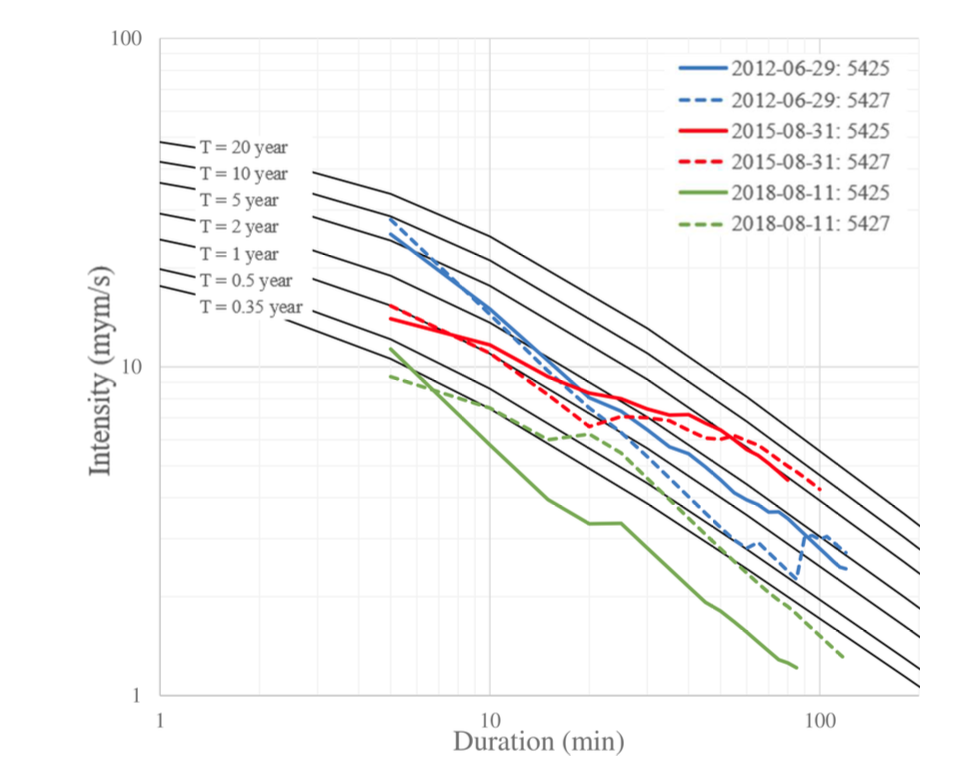